In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
df = pd.read_csv('time_series_covid19_confirmed_global_20200731.csv')

In [3]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,4358,4466,4570,4637,4763,4880,4997,5105,5197,5276
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,24872,25484,26159,26764,27357,27973,28615,29229,29831,30394
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,889,889,897,897,897,907,907,918,922,925
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,812,851,880,916,932,950,1000,1078,1109,1148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186400,6.613100,0,0,0,0,0,0,...,747,749,860,862,863,865,867,868,870,871
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1640,1654,1674,1674,1681,1691,1703,1711,1726,1728
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,337,340,340,340,354,354,354,378,378,378
264,NaN,Tajikistan,38.861000,71.276100,0,0,0,0,0,0,...,7015,7060,7104,7150,7192,7235,7276,7320,7366,7409


In [4]:
# 日本のデータのみ抽出する
df = df[df['Country/Region']=='Japan']
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20
139,NaN,Japan,36.204824,138.252924,2,2,2,2,4,4,...,27136,28114,28883,29684,30548,31142,32116,33382,35144,36234


In [5]:
# ５項目目以降（1/22以降）の項目のみにする
df = df.iloc[:,4:].copy()
#１行目の項目を取得
daily_japan=df.iloc[0,:]
# 日付型に変換
daily_japan.index = pd.to_datetime(daily_japan.index)

In [6]:
daily_japan

2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-07-27    31142
2020-07-28    32116
2020-07-29    33382
2020-07-30    35144
2020-07-31    36234
Name: 139, Length: 192, dtype: int64

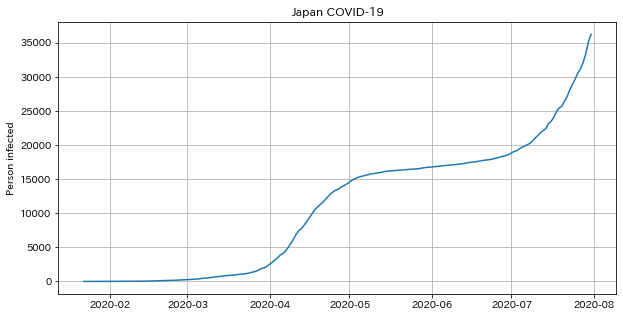

In [7]:
# 日本の感染者数のグラフ
plt.figure(figsize=(10,5))
plt.plot(daily_japan)
plt.title("Japan COVID-19")
plt.grid(True)
plt.ylabel("Person infected")
plt.show()

In [8]:
y=daily_japan.values.astype(float)

In [9]:
# 時系列データを７日をひとつのくくりとして、まとめる。
# ８日目を正解ラベル
def sequence_creator(input_data,window):
    dataset=[]
    data_len = len(input_data)
    for i in range(data_len - window):
        window_fr = input_data[i:i+window]
        label = input_data[i+window:i+window+1]
        dataset.append((window_fr,label))
    return dataset

In [10]:
# LSTMのモデリング
class LSTM_COVID(nn.Module):
    # in_size  ： 入力のノードのサイズ
    # h_size   : 隠れ層のノードのサイズ　（誤差が少なくなるように調整する項目）
    # out_size : 結果のノードのサイズ
    def __init__(self, in_size=1, h_size=30, out_size=1):
        super().__init__()
        
        self.h_size = h_size
        self.lstm = nn.LSTM(in_size, h_size)
        self.fc = nn.Linear(h_size,out_size)
        
        self.hidden = (torch.zeros(1,1,self.h_size), torch.zeros(1,1,self.h_size))
        
    def forward(self, sequence_data):
        lstm_out, self.hidden = self.lstm(sequence_data.view(len(sequence_data),1,-1),self.hidden)
        pred = self.fc(lstm_out.view(len(sequence_data),-1))
        return pred[-1]

# モデルの定義

In [11]:
torch.manual_seed(3)

model = LSTM_COVID()
criterion = nn.MSELoss()
# lr : lrlearning rate)=学習率　どれぐらいの幅でパラメータを更新していくのか（誤差が少なくなるように調整する項目）
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [12]:
window_size = 7
loss_list = []
loss_temp = 0

#model.train()

In [13]:
# 入力の正規化 (-1 から1に収まるように)
scaler = MinMaxScaler(feature_range=(-1,1))
y_normalized = scaler.fit_transform(y.reshape(-1,1))
y_normalized = torch.FloatTensor(y_normalized).view(-1)
full_data = sequence_creator(y_normalized,window_size)

# トレーニング

In [14]:
# 学習の繰り返し
epochs = 300
for epoch in range(epochs):
    # トレーニングデータの件数分ループする
    for sequence_in, y_train in full_data:
        # 予測値計算
        y_pred = model(sequence_in)
        # 損失計算
        loss = criterion(y_pred, y_train)
        loss_temp += loss
        # 勾配を初期化する
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        # パラメータを更新する
        loss.backward()
        optimizer.step()
        
    if((epoch+1) % 10 ==0):
        loss_list.append(loss_temp.item()/(10*len(full_data)))
        print(f'Epoch {epoch+1} Loss {loss_temp.item()/(10*len(full_data))}')
        loss_temp = 0


Epoch 10 Loss 0.02770199749920819
Epoch 20 Loss 0.007244165265882337
Epoch 30 Loss 0.004837487710488809
Epoch 40 Loss 0.0031983166771966057
Epoch 50 Loss 0.0021834819381301466
Epoch 60 Loss 0.0015510773014377904
Epoch 70 Loss 0.001164946427216401
Epoch 80 Loss 0.0009231606045284787
Epoch 90 Loss 0.0007676291465759278
Epoch 100 Loss 0.0006614648973619616
Epoch 110 Loss 0.0005782542357573638
Epoch 120 Loss 0.0005115565093787941
Epoch 130 Loss 0.0004549814559317924
Epoch 140 Loss 0.00040262273840002114
Epoch 150 Loss 0.00035832028131227233
Epoch 160 Loss 0.0003161472887606234
Epoch 170 Loss 0.0002805546167734507
Epoch 180 Loss 0.00024680326113829743
Epoch 190 Loss 0.0002197417858484629
Epoch 200 Loss 0.00019745543196394636
Epoch 210 Loss 0.00017994801740388612
Epoch 220 Loss 0.00016710426356341388
Epoch 230 Loss 0.00015755719429737814
Epoch 240 Loss 0.00015020906925201417
Epoch 250 Loss 0.00014410698736036146
Epoch 260 Loss 0.00013824056934665988
Epoch 270 Loss 0.0001320668007876422
Epoch

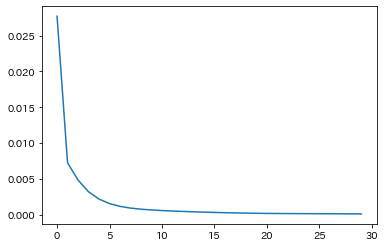

In [15]:
# ロスのプロット
plt.plot(loss_list)

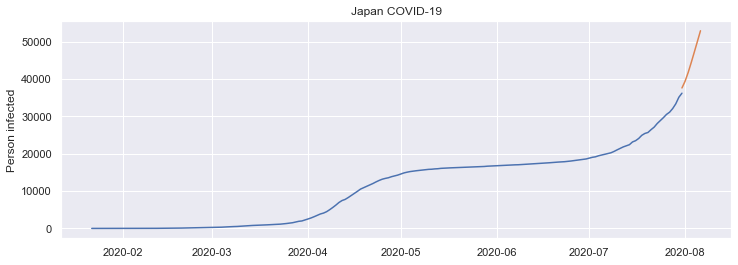

In [18]:
# 将来の７日間の予測
upcoming_future = 7
predictions = y_normalized[-window_size:].tolist()

model.eval()

for i in range(upcoming_future):
    sequence = torch.FloatTensor(predictions[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        predictions.append(model(sequence).item())
        
predictions_y = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
# 7/22　～　7/28 まで（７日間）の予測値を指定する
x = np.arange('2020-07-31','2020-08-07', dtype='datetime64[D]').astype('datetime64[D]')
sns.set()
plt.figure(figsize = (12,4))
plt.title("Japan COVID-19")
plt.grid(True)
plt.ylabel("Person infected")
plt.plot(daily_japan)
plt.plot(x,predictions_y[-window_size:])
plt.show()

In [17]:
# 予測値
predictions_y[-window_size:]

array([[37636.14328671],
       [39413.97412395],
       [41747.8770442 ],
       [44430.28900576],
       [47247.88948536],
       [50100.65249872],
       [52967.28227472]])